# Data wrangling and preparation

# Learning goals:
- Acquire sampla data from SQL.
- Pin down null value, which null should be represented by 0,
- Pin down outliers and decide what to do with them,
- Data structure Aggregate as needed so that every row is an observation and each is a variable 


# Mall customers

In [3]:
# regular imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from env import get_connection

In [4]:
def get_mallcustomer_data():
    df = pd.read_sql('SELECT * FROM customers;', get_connection('mall_customers'))
    return df.set_index('customer_id')

In [5]:
df = get_mallcustomer_data()


In [6]:
type(df)

pandas.core.frame.DataFrame

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,200.0,38.85,13.969007,18.0,28.75,36.0,49.0,70.0
annual_income,200.0,60.56,26.264721,15.0,41.50,61.5,78.0,137.0
spending_score,200.0,50.20,25.823522,1.0,34.75,50.0,73.0,99.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [10]:
df.shape[0]

200

In [13]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [11]:
def nulls_by_col(df):
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    prcnt_miss = num_missing / rows * 100
    cols_missing = pd.DataFrame({'num_rows_missing': num_missing, 'percent_rows_missing': prcnt_miss})
    return cols_missing

def nulls_by_row(df):
    num_missing = df.isnull().sum(axis=1)
    prcnt_miss = num_missing / df.shape[1] * 100
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': prcnt_miss})\
    .reset_index()\
    .groupby(['num_cols_missing', 'percent_cols_missing']).count()\
    .rename(index=str, columns={'customer_id': 'num_rows'}).reset_index()
    return rows_missing

In [14]:
print(nulls_by_row(df).to_markdown())


|    |   num_cols_missing |   percent_cols_missing |   num_rows |
|---:|-------------------:|-----------------------:|-----------:|
|  0 |                  0 |                      0 |        200 |


In [15]:
def summarize(df):
    
    print('=====================================================\n\n')
    print('Dataframe head: ')
    print(df.head(3).to_markdown())
    print('=====================================================\n\n')
    print('Dataframe info: ')
    print(df.info())
    print('=====================================================\n\n')
    print('Dataframe Description: ')
    print(df.describe().to_markdown())
    num_cols = [col for col in df.columns if df[col].dtype != 'O']
    cat_cols = [col for col in df.columns if col not in num_cols]
    print('=====================================================')
    print('DataFrame value counts: ')
    for col in df.columns:
        if col in cat_cols:
            print(df[col].value_counts())
        else:
            print(df[col].value_counts(bins=10, sort=False))
    print('=====================================================')
    print('nulls in dataframe by column: ')
    print(nulls_by_col(df))
    print('=====================================================')
    print('nulls in dataframe by row: ')
    print(nulls_by_row(df))
    print('=====================================================')


In [16]:
summarize(df)




Dataframe head: 
|   customer_id | gender   |   age |   annual_income |   spending_score |
|--------------:|:---------|------:|----------------:|-----------------:|
|             1 | Male     |    19 |              15 |               39 |
|             2 | Male     |    21 |              15 |               81 |
|             3 | Female   |    20 |              16 |                6 |


Dataframe info: 
<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB
None


Dataframe Description: 
|       |     age |   annual_income |   spending_score |
|:------|--------:|----------------:|-----------------:|
| count | 200     |        200    

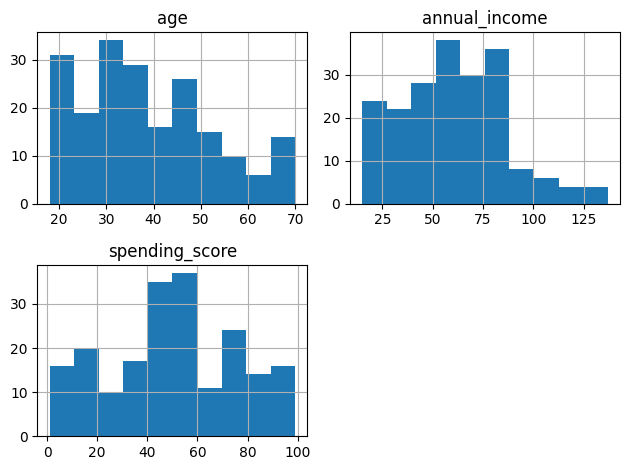

In [17]:
df.hist()
plt.tight_layout()
plt.show()

In [18]:
def remove_columns(df, cols_to_remove):
    df = df.drop(columns=cols_to_remove)
    return df

In [19]:
def handle_missing_values(df, prop_required_columns=0.5, prop_required_row=0.75):
    threshold = int(round(prop_required_columns * len(df.index), 0))
    df = df.dropna(axis=1, thresh=threshold)
    threshold = int(round(prop_required_row * len(df.columns), 0))
    df = df.dropna(axis=0, thresh=threshold)
    return df

In [20]:
# combining everything in a cleaning function:

def data_prep(df, cols_to_remove=[], prop_required_column=0.5, prop_required_row=0.75):
    df = remove_columns(df, cols_to_remove)
    df = handle_missing_values(df, prop_required_column, prop_required_row)
    return df

In [21]:
df = data_prep(df)


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [23]:
# to utilize tukeys method:
# calculate iqr:
# get Q3 and Q1, get difference (q3 - q1)
# establish fences: 
## standard inner fence: 1.5
## standard outer fence: 3
# upper bound: q3 + k * iqr
# lower bound: q1 - k * iqr


In [24]:
def get_upper_outliers(s, k=1.5):
    q1, q3 = s.quantile([.25, 0.75])
    iqr = q3 - q1
    upper_bound = q3 + k * iqr
    return s.apply(lambda x: max([x - upper_bound, 0]))

In [25]:
def add_upper_outlier_columns(df, k=1.5):
    for col in df.select_dtypes('number'):
        df[col + '_outliers_upper'] = get_upper_outliers(df[col], k)
    return df

In [26]:
df = add_upper_outlier_columns(df)
df.head()

,gender,age,annual_income,spending_score,age_outliers_upper,annual_income_outliers_upper,spending_score_outliers_upper
customer_id,,,,,,,
1,Male,19,15,39,0,0.0,0
2,Male,21,15,81,0,0.0,0
3,Female,20,16,6,0,0.0,0
4,Female,23,16,77,0,0.0,0
5,Female,31,17,40,0,0.0,0


In [27]:
outlier_cols = [col for col in df.columns if col.endswith('_outliers_upper')]
for col in outlier_cols:
    print(col, ': ')
    subset = df[col][df[col] > 0]
    print(subset.describe())

age_outliers_upper : 
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: age_outliers_upper, dtype: float64
annual_income_outliers_upper : 
count    2.00
mean     4.25
std      0.00
min      4.25
25%      4.25
50%      4.25
75%      4.25
max      4.25
Name: annual_income_outliers_upper, dtype: float64
spending_score_outliers_upper : 
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: spending_score_outliers_upper, dtype: float64


In [28]:
# we have:
# in an organized fashion:
# acquired our data
# examined the structure and integrity of the data
# we hav observed descriptive statistics (univariate)
# we have examined null values in a nuanced fashion
# we have examined where our outliers live and assessed how we want to approach them
 # (Takeaway: our outliers exist in income, they appear to be valid and I will not 
    # drop them at this time)
